In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import os
import zipfile
from IPython.display import Image

# Data Pre-processing Pipeline

Before the pre-processing pipeline, a symbolic link should be made between this repo's `/data/raw` directory and the user's machine. #TODO

In our data processing pipeline, we load in pairs of `.fastq.gz` files for each brain sample. For each pair of `SRRXXXXXXX_1.fastq.gz` and `SRRXXXXXXX_2.fastq.gz` file, we must perform quality control on them to ensure that they are good quality samples. Here, we use the `FastQC` software to ensure that they are good-quality RNA-seq read data. 

Then, we use the `cutadapt` tool to remove irrelevant parts of the read, like 3' adapters that can be added during the RNA-seq process, or even entire reads if they are bad-quality reads.

## FastQC

The first step in our pre-processing pipeline involves using `FastQC` on each `fastq.gz` file. For the purposes of Checkpoint 2, we performed quality checks using `FastQC` on a sample of 10 files (5 pairs of samples).

Here is the sample input parameters and output of `FastQC` on a pair of files:

In [2]:
# fq_location = '/opt/FastQC/fastqc'
# os.system(fq_location + ' /datasets/srp073813/SRR3438555_1.fastq.gz /datasets/srp073813/SRR3438555_2.fastq.gz'
#          + ' --outdir /datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/fastqc_test')

Sample `FastQC` output:

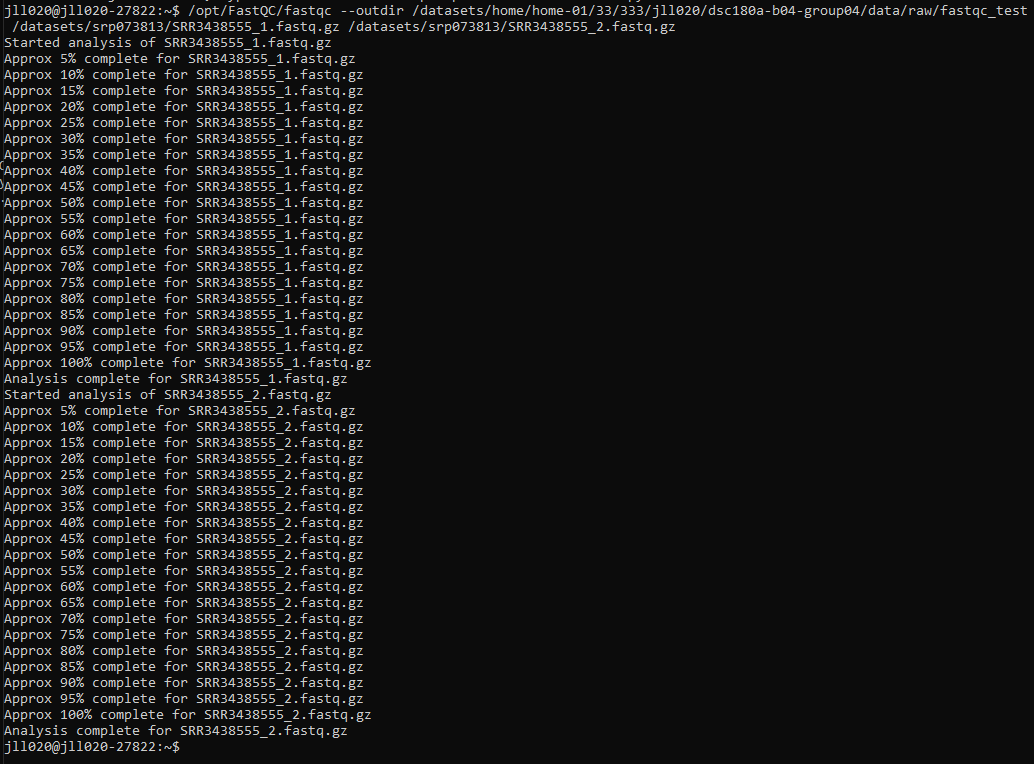

In [3]:
Image(filename="/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/images/FastqcSample.png")

In [4]:
fq_output = []
for i in os.listdir('/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/fastqc_test'):
    if i.endswith('zip') or i.endswith('html'):
        fq_output.append(i)
sorted(fq_output)

['SRR3438555_1_fastqc.html',
 'SRR3438555_1_fastqc.zip',
 'SRR3438555_2_fastqc.html',
 'SRR3438555_2_fastqc.zip']

As we can see from one `FastQC` run, the software outputs a `.zip` file with specific information on the run, as well as an overall report of the quality of the sample in an `.html` file.

Below, we will work on the sample of 10 files that we have already ran using our `run.py` script. 

We first look at the the HTML reports that `FastQC` generated. 

In [5]:
fastqc_files = os.listdir('/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/fastqc_temp_bc')
htmls = []
for i in sorted(fastqc_files):
    if i.endswith('html'):
        htmls.append(i)
htmls

['SRR3438555_1_fastqc.html',
 'SRR3438555_2_fastqc.html',
 'SRR3438556_1_fastqc.html',
 'SRR3438556_2_fastqc.html',
 'SRR3438557_1_fastqc.html',
 'SRR3438557_2_fastqc.html',
 'SRR3438558_1_fastqc.html',
 'SRR3438558_2_fastqc.html',
 'SRR3438559_1_fastqc.html',
 'SRR3438559_2_fastqc.html']

In [6]:
adapter_check = {}
for i in htmls:
    fastqc_path = '/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/fastqc_temp_bc'
    path = os.path.join(fastqc_path, i)
    soup = BeautifulSoup(open(path), 'html.parser')
    check = soup.find_all('div', attrs= {'class':"module"})[8].find('p').text
    adapter_check[i] = check
adapter_check

{'SRR3438555_1_fastqc.html': 'No overrepresented sequences',
 'SRR3438555_2_fastqc.html': 'No overrepresented sequences',
 'SRR3438556_1_fastqc.html': 'No overrepresented sequences',
 'SRR3438556_2_fastqc.html': 'No overrepresented sequences',
 'SRR3438557_1_fastqc.html': 'No overrepresented sequences',
 'SRR3438557_2_fastqc.html': 'No overrepresented sequences',
 'SRR3438558_1_fastqc.html': 'No overrepresented sequences',
 'SRR3438558_2_fastqc.html': 'No overrepresented sequences',
 'SRR3438559_1_fastqc.html': 'No overrepresented sequences',
 'SRR3438559_2_fastqc.html': 'No overrepresented sequences'}

From the output above, we can conclude `FastQC` confirms that our reads do not include 'overrepresented sequences', which are normally sequences not found in the human genome, possibly 3' adapters or erroneous sequences. 

Now, we process the `.zip` files, which contain the specific metadata of each read. We will look specifically at the `fastqc_data.txt` file that is generated by each run of `FastQC`, which includes basic statistics on the run, sequence qualities, and most importantly, a 'pass/fail' flag.

In [7]:
zips = []
for i in sorted(fastqc_files):
    if i.endswith('zip'):
        zips.append(i)

In [8]:
for i in zips:
    fastqc_path = '/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/fastqc_temp_bc'
    zip_path = os.path.join(fastqc_path, i)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.join('/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/fastqc_test', i.split('.')[0]))

In [9]:
zippers = os.listdir('/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/fastqc_test')
pass_check = {}
for i in sorted(zippers):
    if (i.endswith('html')==False) and (i.endswith('zip')==False) and (i.endswith('points')==False):
        zippers_path = '/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/fastqc_test'
        path = os.path.join(zippers_path, i, i, 'fastqc_data.txt')
        f = open(path, 'r')
        pass_check[i] = f.readlines()[1][-5:-1]
pass_check

{'SRR3438555_1_fastqc': 'pass',
 'SRR3438555_2_fastqc': 'pass',
 'SRR3438556_1_fastqc': 'pass',
 'SRR3438556_2_fastqc': 'pass',
 'SRR3438557_1_fastqc': 'pass',
 'SRR3438557_2_fastqc': 'pass',
 'SRR3438558_1_fastqc': 'pass',
 'SRR3438558_2_fastqc': 'pass',
 'SRR3438559_1_fastqc': 'pass',
 'SRR3438559_2_fastqc': 'pass'}

This metadata confirms that our reads are good-quality reads. As stated above, if there are low-quality reads or sequences, we should use `cutadapt` to remove the sub-standard reads. Since `FastQC` tells us that all the reads have no overrepresented sequences (aka adapters) and that all our reads passed the "pass/fail" check, we may not need to run `cutadapt` for these sample reads, because there is nothing extraneous to remove. This may not be true for **all** our reads, though, so we should still run it to be safe.  

## cutadapt

Based on the results of `FastQC`, most of our samples are 'clean', which means that it does not have any bad sequence reads. However, for demonstration purposes, we still want to show how to utilize `cutadapt` for the purpose of cutting away the adapters and bad sequences.

Here, we need both reads of a pair of samples; the adapter parameters in the `-a` and the `-A` are default adapters (`AACCGGTT`); these may differ based on the read and what adapters were used (specifically the ones added during the Illumina process):

In [10]:
# os.system('cutadapt -a AACCGGTT -A AACCGGTT ' + 
#           '-o /datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/cutadapt_test/out.1.fastq.gz ' +
#           '-p /datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/cutadapt_test/out.2.fastq.gz ' +
#           '/datasets/srp073813/SRR3438555_1.fastq.gz ' +
#           '/datasets/srp073813/SRR3438555_2.fastq.gz --cores=8')

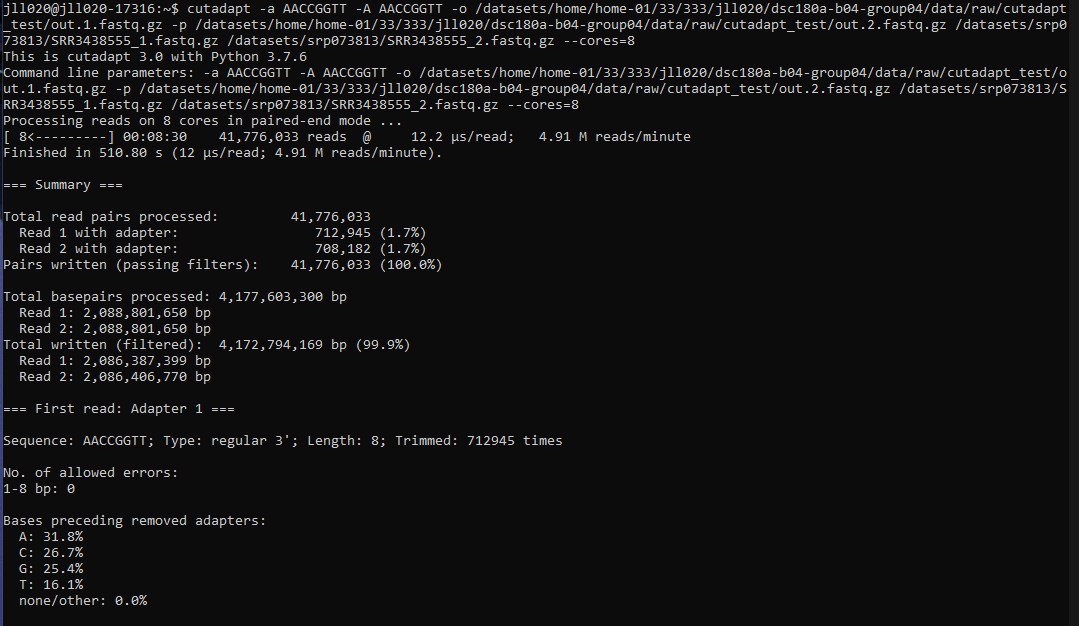

In [11]:
Image(filename="/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/images/CutadaptSample.png")

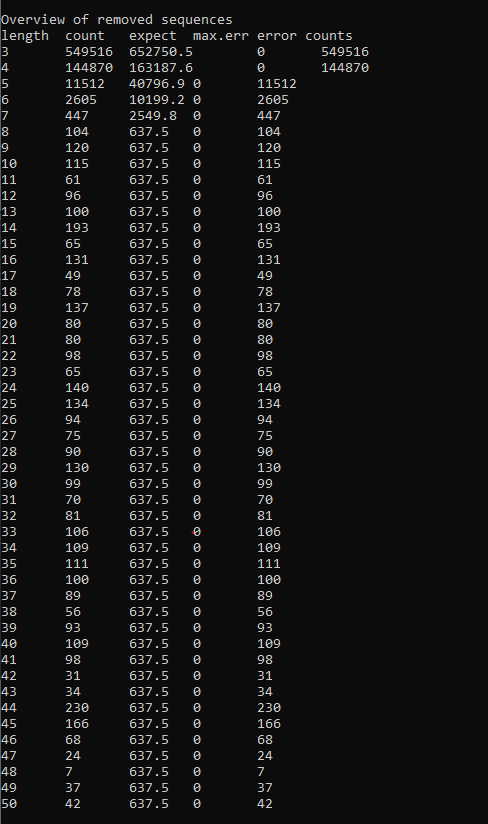

In [12]:
Image(filename="/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/images/CutadaptSample1.png")

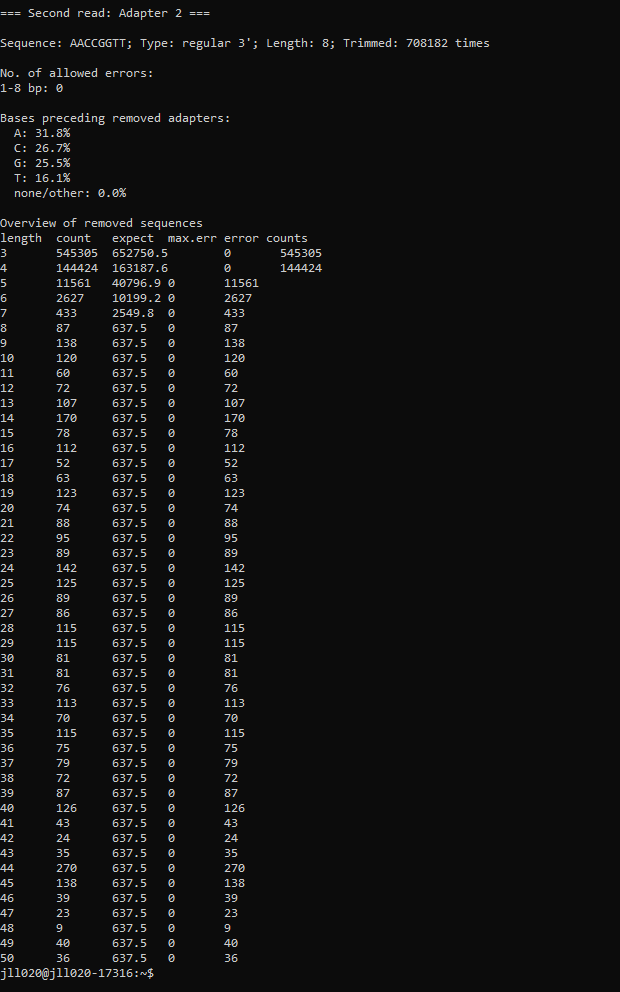

In [13]:
Image(filename="/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/images/CutadaptSample2.png")

In [14]:
lst = []
for i in os.listdir('/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/cutadapt_test'):
    if i.endswith('gz'): #avoiding outputting .ipynb_checkpoints??
        lst.append(i)
sorted(lst)

['out.1.fastq.gz', 'out.2.fastq.gz']

The images show the output of `cutadapt`. Again, we only use `cutadapt` when FastQC tells us that a read is bad-quality or has adapters. The output above shows a report generated by `cutadapt` on one pair of samples, and summarizes how many times the specified adapter was removed from each read. (Here, the specified adapter is the default `AACCGGTT` adapter; the Illumina process that did RNA-seq may have used a different adapter, and `FastQC` would tell us any possible adapter sequences in its report, which we would use here). In our command, we specified the output files to be new `.fastq.gz` files in our `data/raw` folder, because `cutadapt` takes in FASTQ files and outputs "cleaned" FASTQ files (again, if necessary). We can then proceed with `Kallisto` to perform alignment on the cleaned files. 

## Kallisto

After quality control of the data is finished, we need to perform alignment of each of the pairs to "combine" the information of the paired-end data. This allows us to quantify the expressions of the reads. To do the alignment, we have decided to use the `Kallisto` tool. Using a reference genome generated by `Kallisto`, we perform alignment of the RNA samples to quantify gene expression.

In [15]:
# os.system("/opt/kallisto_linux-v0.42.4/kallisto quant " +
#                "-i /datasets/srp073813/reference/kallisto_transcripts.idx -b 30 "
#                "-o /datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/kallisto_test " +
#                "/datasets/srp073813/SRR3438555_1.fastq.gz " + 
#                "/datasets/srp073813/SRR3438555_2.fastq.gz")

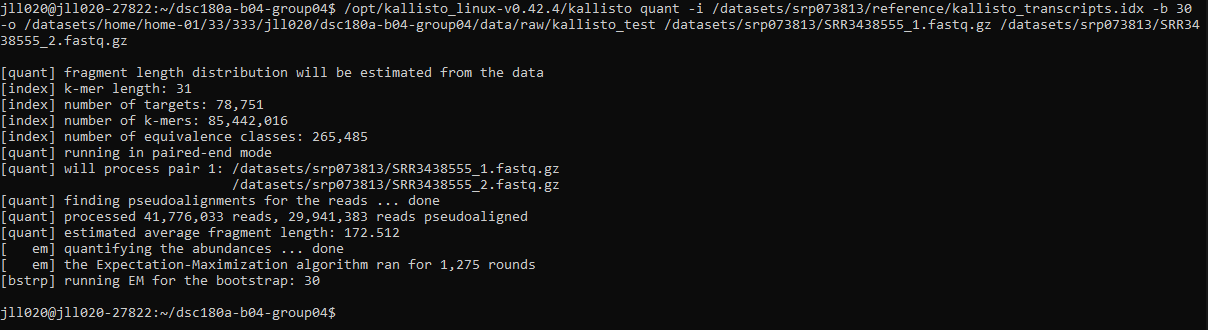

In [16]:
Image(filename = '/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/images/KallistoSample.png')

Below are the files (provided by Shannon) that are used in when aligning with `Kallisto`. We use the `kallisto_transcripts.idx` file to align each pair of files, using 30 bootstraps (should be 100 in practice). 

In [17]:
os.listdir('/datasets/srp073813/reference')

['GRCh37_latest_genomic.gff',
 'GRCh37_latest_rna.fa.gz',
 'GRCh37_latest_genomic.fa.gz',
 'kallisto_transcripts.idx']

These are the counts that are created by `Kallisto`. The `run_info.json` just gives some metadata about the `Kallisto` run, while the `abundance` data is the counts. 

In [18]:
os.listdir('/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/kallisto_test')

['run_info.json', 'abundance.h5', 'abundance.tsv']

In [19]:
abundance = pd.read_csv('/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/kallisto_test/abundance.tsv', sep='\t')
abundance

,target_id,length,eff_length,est_counts,tpm
0,NM_000014.6,4610,4438.490,3747.5600,75.070500
1,NM_000015.3,1285,1113.490,0.0000,0.000000
2,NM_000016.6,2261,2089.490,392.9280,16.719700
3,NM_000017.4,1859,1687.490,371.8200,19.590600
4,NM_000018.4,2184,2012.490,4365.3100,192.858000
...,...,...,...,...,...
78746,NR_170930.1,5594,5422.490,0.0000,0.000000
78747,NR_170931.1,5401,5229.490,25.9308,0.440872
78748,NR_170932.1,623,452.071,61.1665,12.029900
78749,NR_170933.1,1086,914.488,7.9105,0.769098


## Picard

Picard is used to perform quality control on the alignment done by Kallisto.

## DeSEQ2

The R-based tool, DeSEQ2, performs gene differential expression analysis on the output of the alignment. The tool normalizes the output of the alignment and returns the counts for each gene in the alignment, giving us informtation